In [1]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.metrics import *
from collections import Counter
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.utils import compute_class_weight
from sklearn.model_selection import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [2]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [3]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        image
        images.append(image)
        labels.append(image_features['label'].numpy())

In [5]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
          '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
          '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
          '../input/ddsm-mammography/training10_4/training10_4.tfrecords'
          ]

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
55885
55885


In [6]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=True,stratify=y)

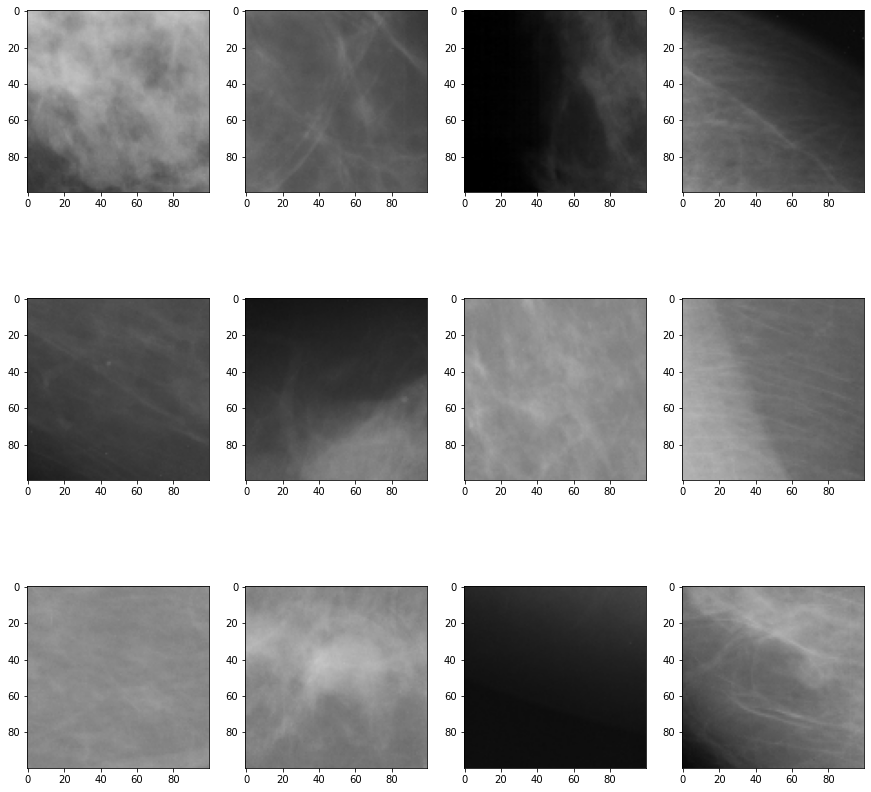

In [7]:
fig=plt.figure(figsize=(15,15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[i])
plt.show()


In [8]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 3)


In [9]:
y_count=pd.DataFrame(y_train)
y_count.value_counts()

0    34017
1     1472
2     1338
4     1268
3     1024
dtype: int64

In [10]:
weights={0:0.869,1:0.037,2:0.034,3:0.026,4:0.032}

In [11]:
base_model = VGG19(input_shape=(100,100,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4608)              18432     
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________

In [12]:
c1= tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
c2=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001)

In [13]:
Y_train=to_categorical(y_train,5)
Y_test=to_categorical(y_test,5)

In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history = model.fit(x_train, Y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=128,callbacks=[c1,c2],
                   class_weight=weights)

Epoch 1/50
245/245 [==============================] - 27s 90ms/step - loss: 0.2900 - accuracy: 0.7829 - auc: 0.9070 - val_loss: 0.7431 - val_accuracy: 0.8687 - val_auc: 0.9494
Epoch 2/50
245/245 [==============================] - 20s 84ms/step - loss: 0.0279 - accuracy: 0.8744 - auc: 0.9532 - val_loss: 0.6835 - val_accuracy: 0.8694 - val_auc: 0.9563
Epoch 3/50
245/245 [==============================] - 20s 84ms/step - loss: 0.0241 - accuracy: 0.8782 - auc: 0.9641 - val_loss: 0.6650 - val_accuracy: 0.8709 - val_auc: 0.9594
Epoch 4/50
245/245 [==============================] - 20s 84ms/step - loss: 0.0224 - accuracy: 0.8804 - auc: 0.9676 - val_loss: 0.6646 - val_accuracy: 0.8710 - val_auc: 0.9608
Epoch 5/50
245/245 [==============================] - 20s 83ms/step - loss: 0.0204 - accuracy: 0.8826 - auc: 0.9725 - val_loss: 0.6722 - val_accuracy: 0.8724 - val_auc: 0.9605
Epoch 6/50
245/245 [==============================] - 20s 83ms/step - loss: 0.0192 - accuracy: 0.8856 - auc: 0.9742 - va

In [15]:
y_pred=np.argmax(model.predict(x_test),axis=-1)
y_pred_prb=model.predict_proba(x_test)
target=["0","1","2","3","4"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),5))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),5))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.88334
Precision: 0.84618
Recall: 0.88334
F1 Score: 0.84505
ROC AUC Score: 0.86927
Cohen Kappa Score: 0.25152
		Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     14579
           1       0.52      0.09      0.15       631
           2       0.40      0.09      0.15       573
           3       0.52      0.03      0.05       439
           4       0.69      0.32      0.44       544

    accuracy                           0.88     16766
   macro avg       0.61      0.30      0.35     16766
weighted avg       0.85      0.88      0.85     16766



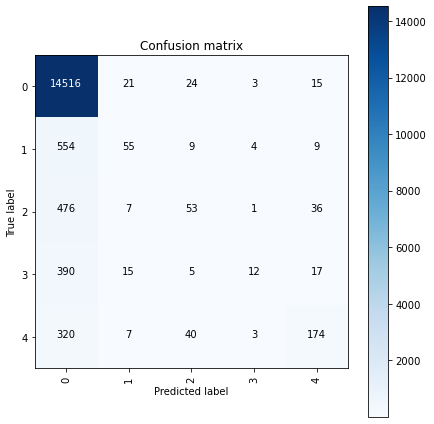

In [16]:
pred=np.argmax(model.predict(x_test),axis=-1)
cm=confusion_matrix(y_test,pred)
cm_plot=plot_confusion_matrix(cm,classes=['0','1','2','3','4'])